In [1]:
import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import operator
import os
from sklearn.cross_validation import train_test_split
from random import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import StratifiedKFold
import tqdm
%matplotlib inline

#PLOT CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import itertools
import pickle
#matrix inverse
from numpy.linalg import inv
import jj_basic_fn as JJ
from hyperparams import Hyperparams as hp
from patient import patient
import prep
import plot_funcs
import modules
#default size of the graph
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_colwidth', -1)

n_classifier = 7

col_rs = hp.col_rs
col_es = hp.col_es
col_le = hp.col_le



/Users/hp/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hp/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [15]:
# [p241,p226] = modules.build_patients(-2, 90)
# pat_list = [p241,p226]
#p241 = modules.build_patients(241, 90)
#p231 = modules.build_patients(231, 90)
# p231, p222_1, p222_2, p229 = modules.build_patients(-1,90, if_weekly = 1)
# pat_list = [p231, p222_1, p222_2, p229]
# for pat in pat_list:
#     JJ.save_object(pat, '../patients/' + pat.id +'.p')
p231, p222_1, p222_2, p241 = modules.build_patients(-3,90, if_weekly = 0)
pat_list = [p231, p222_1, p222_2, p241]

/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


231
good:  537
bad:  356
total:  893


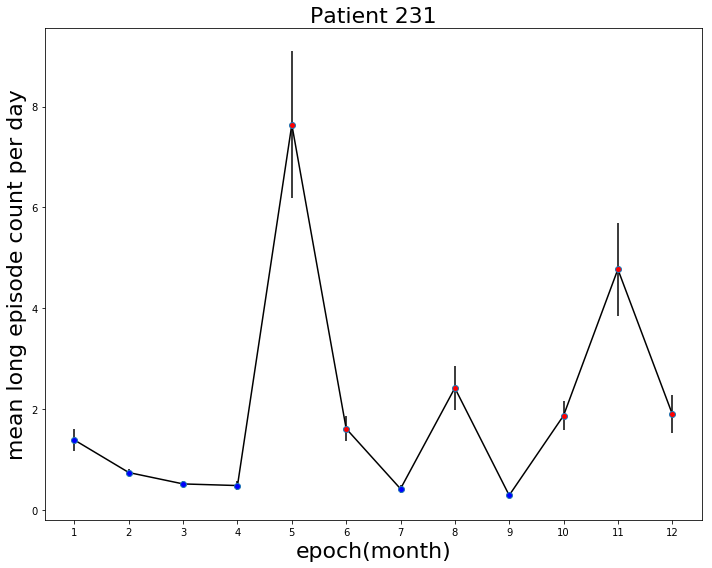

222_1
good:  276
bad:  452
total:  728


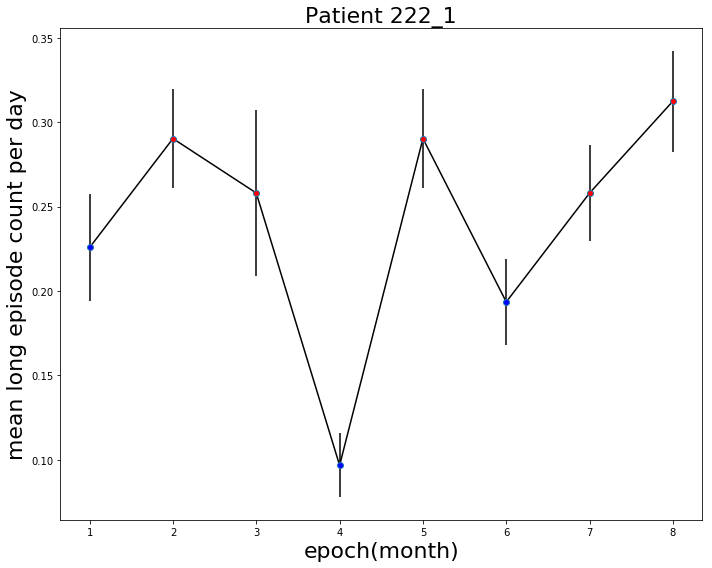

222_2
good:  265
bad:  359
total:  624


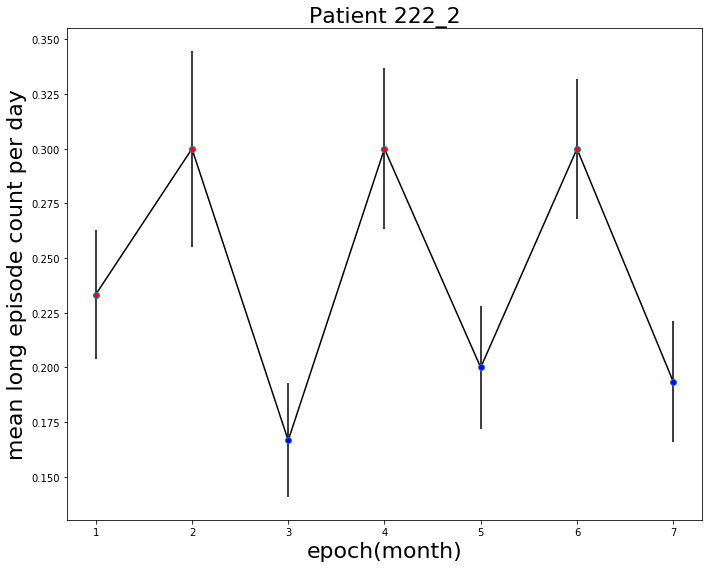

241
good:  281
bad:  288
total:  569


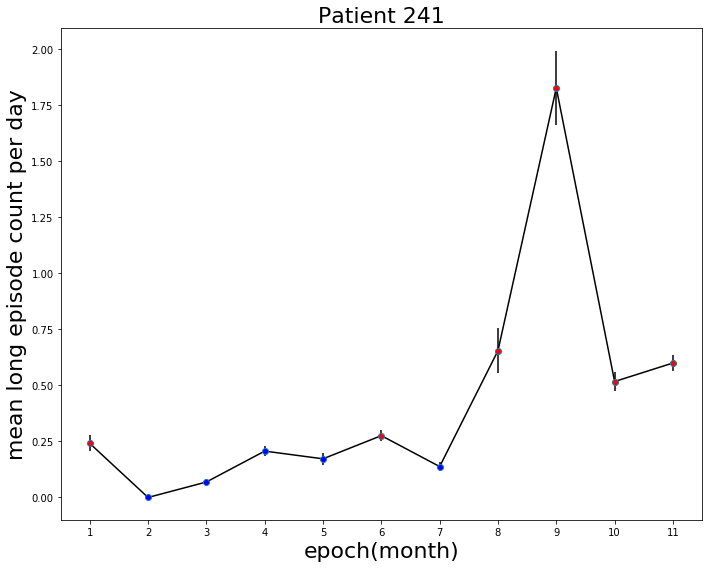

In [16]:
plot_funcs.plot_epoch_mean(pat_list, if_save = 1, label = '')


In [37]:
X = np.arange(10)
y = np.zeros(10)
z = [0,0,0,0,0,1,1,1,1,1]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = z, test_size=0.8, random_state =93)
print(X_train)

[2 7]


In [5]:
def parameter_tuning(pat, X_train, X_test, y_train, y_test, classifier, C_range_num = 30, if_save = 0,
                     nfold = 10, if_show = 1):
    #defs is a dictionary to initiate classifier with the parameters that don't need to be tuned
    defs = {}
    defs['classifier'] = classifier
    
    num_instances, num_features = X_train.shape[0], X_train.shape[1]
    n_fold = 10

    skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
    CV = skf.split(np.zeros(len(y_train)), y_train)
    

    if classifier==1:
        clf_name = 'Logistic Regression'
        defs['class_weight'] = 'balanced'
        defs['max_iter'] = 200
        C_range = 10 ** np.random.uniform(-2, 1, size = C_range_num)
        tuned_params = dict(penalty=['l1','l2'], C=C_range)
    elif classifier == 2: 
        clf_name = 'SVM'
        defs['class_weight'] = 'balanced'
        kernel_list = ['rbf']    
        gamma_list = [2**i*1/num_features for i in range(1)]
        #degree_list = [2,3,4,5]
        C_range = 10 ** np.random.uniform(-3, 1, size = C_range_num)
        tuned_params = dict(kernel=kernel_list,gamma = gamma_list, C=C_range)

    elif classifier==3:
        clf_name = 'Gaussian Naive Bayes classifier'
        prr = np.ones(2) * (1.0/2)
        defs['priors'] = prr
        clf_try = JJ.clf_list(defs)
        clf_try.fit(X_train, y_train)
        pat.estimator[classifier] = clf_try
        return

    elif classifier==4:
        clf_name = 'Linear Discriminant Analysis'
        prr = np.ones(2) * (1.0/2)
        defs['solver'] = 'eigen'  # 'svd', 'lsqr', 'eigen'
        defs['shrinkage'] = 'auto'
        defs['priors'] = prr
        clf_try = JJ.clf_list(defs)
        clf_try.fit(X_train, y_train)
        pat.estimator[classifier] = clf_try
        return
    elif classifier == 5:
        clf_name = 'decision tree'
        mss_list = [5,10,20,40,60]
        criterion_list = ['entropy']
        max_depth_list = [3,4,5,8,12,18]
        clf_name = 'decision tree'
        tuned_params = dict(criterion=criterion_list, min_samples_split=mss_list, max_depth = max_depth_list)
    elif classifier == 6:
        clf_name = 'random forest'
        defs['n_estimators'] = 600
        mss_list = [20,25,30,40]
        criterion_list = ['entropy']
        max_depth_list = [12,13,14,15,16]
        max_features_list = ['auto']
        tuned_params = dict(criterion=criterion_list, min_samples_split=mss_list, max_depth = max_depth_list, max_features = max_features_list)
    elif classifier == 7:
        clf_name = 'gradient boosting'
        defs['n_estimators'] = 2000
        max_depth_list, subsample_list, learning_rate_list, min_samples_leaf_list = [1,2,3], [0.1,0.15,0.2, 0.3, 0.4], [0.02, 0.01,0.005], [10,20,30] 
        #params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
        #  'learning_rate': 0.01, 'min_samples_leaf': 10, 'random_state': 3}
        tuned_params = dict(max_depth=max_depth_list, subsample = subsample_list,learning_rate = learning_rate_list, min_samples_leaf= min_samples_leaf_list)
    
        
    clf_try = JJ.clf_list(defs)
    
    clf_grid = GridSearchCV(clf_try,
                            param_grid=tuned_params,
                            cv=CV,
                            scoring = 'roc_auc',
                            verbose=1,
                           return_train_score = True)
    clf_grid.fit(X_train, y_train)
    print('Best score for validations set: {}'.format(clf_grid.best_score_))
    print('Best parameters: {}'.format(clf_grid.best_params_))

    clf_best = clf_grid.best_estimator_

    y_pred = clf_best.predict(X_test)
    df = pd.DataFrame(clf_grid.cv_results_)
    if if_show:
        JJ.show_result(y_pred, y_test, df, clf_name, if_save = if_save)
    
    if if_save:
        pat.result[classifier] = df
        pat.estimator[classifier] = clf_best
        pat.score[classifier] = clf_grid.best_score_
        pat.params[classifier] = clf_grid.best_params_



In [6]:
# X_train, X_test, y_train, y_test = modules.get_ml_data(p2, if_remove_icd = 1, if_remove_sleep=1, if_remove_le=0, le_class = 1)
# parameter_tuning(p229,X_train, X_test, y_train, y_test,1, C_range_num = 100, 
#                      nfold = 10, if_save = 0, if_show = 1)

In [7]:
def parameter_tuning_all(pat, C_range_num, label = '', if_scaler = 1, if_remove_icd = 1, if_remove_sleep=1, if_remove_le = 1, le_class = None, sleep_class =None, if_save = 1, if_show = 0, if_remove_delta = 1, if_remove_outliers = 0):
    X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_scaler = if_scaler, if_remove_icd = if_remove_icd, if_remove_sleep = if_remove_sleep, if_remove_le = if_remove_le, sleep_class = sleep_class, le_class = le_class, if_remove_delta = if_remove_delta, if_remove_outliers = if_remove_outliers)
    train_para = {}
    train_para['if_scaler'], train_para['if_remove_icd'], train_para['if_remove_sleep'], train_para['if_remove_le'] \
    , train_para['le_class'], train_para['if_remove_delta'], train_para['if_remove_outliers'] = \
    if_scaler, if_remove_icd, if_remove_sleep, if_remove_le, le_class, if_remove_delta, if_remove_outliers
    pat.train_para = train_para
    pat.X_train, pat.X_test, pat.y_train, pat.y_test = X_train, X_test, y_train, y_test
    for classifier_int in tqdm.trange(1,hp.num_classifier + 1):
        parameter_tuning(pat, X_train, X_test, y_train, y_test, C_range_num = C_range_num, classifier = classifier_int, if_save = if_save, if_show = if_show)
        #save the best estimator
        JJ.scores_estimators(X_test, y_test, pat= pat, if_save = 0)
    if if_save:
        JJ.save_object(pat, hp.prepath_pat + pat.id + '_trained' + label + '.p')

In [10]:
parameter_tuning_all(p241, label = '', C_range_num = 100, if_save = 1)
parameter_tuning_all(p241, label = '_sleep', if_remove_sleep=0, C_range_num = 100, if_save = 1)
parameter_tuning_all(p241, label = '_sleep_sleep', sleep_class = 1, C_range_num = 100, if_save = 1)
parameter_tuning_all(p241, label = '_sleep_awake', sleep_class = 0, C_range_num = 100, if_save = 1)



  0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   10.5s finished


 14%|█▍        | 1/7 [00:10<01:02, 10.49s/it]

Best score for validations set: 0.8036137775268208
Best parameters: {'C': 0.43238730458253855, 'penalty': 'l2'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   14.0s finished


 29%|██▊       | 2/7 [00:24<01:01, 12.28s/it]

Best score for validations set: 0.8248316900490812
Best parameters: {'C': 9.566053822850018, 'kernel': 'rbf', 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.1s finished


 71%|███████▏  | 5/7 [00:26<00:10,  5.34s/it]

Best score for validations set: 0.7279524823003083
Best parameters: {'max_depth': 12, 'min_samples_split': 60, 'criterion': 'entropy'}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.6min finished


 86%|████████▌ | 6/7 [04:03<00:40, 40.57s/it]

Best score for validations set: 0.7988793814880772
Best parameters: {'max_depth': 14, 'max_features': 'auto', 'min_samples_split': 20, 'criterion': 'entropy'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 21.4min finished


100%|██████████| 7/7 [25:28<00:00, 218.42s/it]



  0%|          | 0/7 [00:00<?, ?it/s]

Best score for validations set: 0.8132563089084829
Best parameters: {'min_samples_leaf': 30, 'max_depth': 3, 'learning_rate': 0.005, 'subsample': 0.4}
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   23.3s finished


 14%|█▍        | 1/7 [00:23<02:20, 23.34s/it]

Best score for validations set: 0.8020761846848802
Best parameters: {'C': 1.5454417947894434, 'penalty': 'l2'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   15.6s finished


 29%|██▊       | 2/7 [00:38<01:37, 19.49s/it]

Best score for validations set: 0.8352690787473397
Best parameters: {'C': 5.610660589452424, 'kernel': 'rbf', 'gamma': 0.04}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.3s finished


 71%|███████▏  | 5/7 [00:41<00:16,  8.26s/it]

Best score for validations set: 0.7279524823003083
Best parameters: {'max_depth': 12, 'min_samples_split': 60, 'criterion': 'entropy'}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.8min finished


 86%|████████▌ | 6/7 [04:28<00:44, 44.76s/it]

Best score for validations set: 0.8028840724492898
Best parameters: {'max_depth': 14, 'max_features': 'auto', 'min_samples_split': 20, 'criterion': 'entropy'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 21.4min finished


100%|██████████| 7/7 [25:56<00:00, 222.31s/it]



  0%|          | 0/7 [00:00<?, ?it/s]

Best score for validations set: 0.8161403813577727
Best parameters: {'min_samples_leaf': 20, 'max_depth': 3, 'learning_rate': 0.005, 'subsample': 0.4}
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    8.1s finished


 14%|█▍        | 1/7 [00:08<00:48,  8.13s/it]

Best score for validations set: 0.8045255183413079
Best parameters: {'C': 0.3042536469173479, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    5.7s finished


 29%|██▊       | 2/7 [00:13<00:34,  6.93s/it]

Best score for validations set: 0.8198431685273792
Best parameters: {'C': 2.0640083343187525, 'kernel': 'rbf', 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.4s finished


 71%|███████▏  | 5/7 [00:15<00:06,  3.05s/it]

Best score for validations set: 0.7101774322169059
Best parameters: {'max_depth': 5, 'min_samples_split': 20, 'criterion': 'entropy'}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.8min finished


 86%|████████▌ | 6/7 [03:05<00:30, 30.98s/it]

Best score for validations set: 0.8078814460393409
Best parameters: {'max_depth': 14, 'max_features': 'auto', 'min_samples_split': 20, 'criterion': 'entropy'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 14.7min finished


100%|██████████| 7/7 [17:45<00:00, 152.24s/it]



  0%|          | 0/7 [00:00<?, ?it/s]

Best score for validations set: 0.8047248803827752
Best parameters: {'min_samples_leaf': 10, 'max_depth': 2, 'learning_rate': 0.005, 'subsample': 0.3}
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    9.4s finished


 14%|█▍        | 1/7 [00:09<00:56,  9.39s/it]

Best score for validations set: 0.863100026816841
Best parameters: {'C': 8.337153555194508, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    5.0s finished


 29%|██▊       | 2/7 [00:14<00:35,  7.19s/it]

Best score for validations set: 0.8751676052561008
Best parameters: {'C': 3.2416405690009165, 'kernel': 'rbf', 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.2s finished


 71%|███████▏  | 5/7 [00:15<00:06,  3.13s/it]

Best score for validations set: 0.7415191740412979
Best parameters: {'max_depth': 18, 'min_samples_split': 40, 'criterion': 'entropy'}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


 86%|████████▌ | 6/7 [02:47<00:27, 27.96s/it]

Best score for validations set: 0.8376240278895146
Best parameters: {'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 20, 'criterion': 'entropy'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 14.4min finished


100%|██████████| 7/7 [17:13<00:00, 147.66s/it]



Best score for validations set: 0.8543175113971574
Best parameters: {'min_samples_leaf': 10, 'max_depth': 2, 'learning_rate': 0.02, 'subsample': 0.3}


In [13]:
parameter_tuning_all(p229, label = '', if_remove_delta = 1, C_range_num = 100, if_save = 1)
# parameter_tuning_all(p222_1, label = '_124_d_no', if_remove_delta = 0, C_range_num = 100, if_save = 1)
# parameter_tuning_all(p231, label = '_124_d_no', if_remove_delta = 0, C_range_num = 100, if_save = 1)
# parameter_tuning_all(p229, label = '_124_d_no', if_remove_delta = 0, C_range_num = 100, if_save = 1)



  0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   14.0s finished


 14%|█▍        | 1/7 [00:14<01:24, 14.02s/it]

Best score for validations set: 0.792458241087557
Best parameters: {'C': 0.042940113060984816, 'penalty': 'l2'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   32.7s finished


 29%|██▊       | 2/7 [00:46<01:56, 23.37s/it]

Best score for validations set: 0.8064236687758108
Best parameters: {'C': 0.7262545920359577, 'kernel': 'rbf', 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.9s finished


 71%|███████▏  | 5/7 [00:50<00:20, 10.14s/it]

Best score for validations set: 0.6844751283190382
Best parameters: {'max_depth': 4, 'min_samples_split': 5, 'criterion': 'entropy'}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.7min finished


 86%|████████▌ | 6/7 [05:34<00:55, 55.80s/it]

Best score for validations set: 0.8005543050300084
Best parameters: {'max_depth': 16, 'max_features': 'auto', 'min_samples_split': 20, 'criterion': 'entropy'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 27.5min finished


100%|██████████| 7/7 [33:05<00:00, 283.69s/it]



Best score for validations set: 0.8053785581958536
Best parameters: {'min_samples_leaf': 10, 'max_depth': 3, 'learning_rate': 0.005, 'subsample': 0.2}


In [14]:
parameter_tuning_all(p222_2, C_range_num = 100, if_save = 1)
parameter_tuning_all(p222_1, C_range_num = 100, if_save = 1)
parameter_tuning_all(p231, C_range_num = 100, if_save = 1)
parameter_tuning_all(p229, C_range_num = 100, if_save = 1)


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   14.6s finished

 14%|█▍        | 1/7 [00:14<01:27, 14.61s/it]

Best score for validations set: 0.7185552624879555
Best parameters: {'C': 0.19732435263241271, 'penalty': 'l2'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   17.7s finished

 29%|██▊       | 2/7 [00:32<01:20, 16.18s/it]

Best score for validations set: 0.7144266140880058
Best parameters: {'kernel': 'rbf', 'gamma': 0.041666666666666664, 'C': 5.181443770132869}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.8s finished

 71%|███████▏  | 5/7 [00:35<00:14,  7.04s/it]

Best score for validations set: 0.6438334199373519
Best parameters: {'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 18}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.9min finished

 86%|████████▌ | 6/7 [04:28<00:44, 44.77s/it]

Best score for validations set: 0.7083347916911595
Best parameters: {'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 16, 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 22.2min finished

100%|██████████| 7/7 [26:42<00:00, 228.93s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

Best score for validations set: 0.7301059051974677
Best parameters: {'min_samples_leaf': 10, 'max_depth': 1, 'subsample': 0.2, 'learning_rate': 0.01}
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   13.3s finished

 14%|█▍        | 1/7 [00:13<01:19, 13.30s/it]

Best score for validations set: 0.6595751908952269
Best parameters: {'C': 0.06691476579163282, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   22.8s finished

 29%|██▊       | 2/7 [00:36<01:30, 18.06s/it]

Best score for validations set: 0.6676549772134711
Best parameters: {'kernel': 'rbf', 'gamma': 0.041666666666666664, 'C': 4.987347424406421}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.0s finished

 71%|███████▏  | 5/7 [00:39<00:15,  7.82s/it]

Best score for validations set: 0.6498224391825915
Best parameters: {'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 4}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.4min finished

 86%|████████▌ | 6/7 [05:03<00:50, 50.52s/it]

Best score for validations set: 0.653768326616825
Best parameters: {'criterion': 'entropy', 'min_samples_split': 30, 'max_depth': 16, 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 23.5min finished

100%|██████████| 7/7 [28:37<00:00, 245.30s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

Best score for validations set: 0.6393723090271723
Best parameters: {'min_samples_leaf': 30, 'max_depth': 1, 'subsample': 0.4, 'learning_rate': 0.005}
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   15.2s finished

 14%|█▍        | 1/7 [00:15<01:31, 15.17s/it]

Best score for validations set: 0.8140460675047885
Best parameters: {'C': 0.4255132143156609, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   28.4s finished

 29%|██▊       | 2/7 [00:43<01:49, 21.82s/it]

Best score for validations set: 0.8188014179208172
Best parameters: {'kernel': 'rbf', 'gamma': 0.041666666666666664, 'C': 1.9106759492160326}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.4s finished

 71%|███████▏  | 5/7 [00:47<00:18,  9.41s/it]

Best score for validations set: 0.7434313474119933
Best parameters: {'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 8}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.3min finished

 86%|████████▌ | 6/7 [05:07<00:51, 51.20s/it]

Best score for validations set: 0.8212585889742158
Best parameters: {'criterion': 'entropy', 'min_samples_split': 25, 'max_depth': 15, 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 25.8min finished

100%|██████████| 7/7 [30:55<00:00, 265.09s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

Best score for validations set: 0.838969094721556
Best parameters: {'min_samples_leaf': 20, 'max_depth': 1, 'subsample': 0.3, 'learning_rate': 0.01}
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   13.0s finished

 14%|█▍        | 1/7 [00:12<01:17, 12.97s/it]

Best score for validations set: 0.7455397360089577
Best parameters: {'C': 0.023470981938415562, 'penalty': 'l2'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   44.9s finished

 29%|██▊       | 2/7 [00:57<02:24, 28.93s/it]

Best score for validations set: 0.7665766359004093
Best parameters: {'kernel': 'rbf', 'gamma': 0.041666666666666664, 'C': 0.8040562033694495}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    4.0s finished

 71%|███████▏  | 5/7 [01:01<00:24, 12.37s/it]

Best score for validations set: 0.7037630857785568
Best parameters: {'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 8}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  5.2min finished

 86%|████████▌ | 6/7 [06:16<01:02, 62.82s/it]

Best score for validations set: 0.7773612124128969
Best parameters: {'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 16, 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 29.6min finished

100%|██████████| 7/7 [35:54<00:00, 307.79s/it]


Best score for validations set: 0.7598987316834481
Best parameters: {'min_samples_leaf': 10, 'max_depth': 3, 'subsample': 0.4, 'learning_rate': 0.005}


In [12]:
parameter_tuning_all(p222_2, C_range_num = 100, if_scaler = 1, 
                     if_remove_icd =1, if_remove_sleep = 0, \
                     le_class = None, if_remove_le = 1, if_save = 1, if_remove_delta = 0)

  0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   17.9s finished
 14%|█▍        | 1/7 [00:17<01:47, 17.90s/it]

Best score for validations set: 0.7245304162587004
Best parameters: {'C': 0.0414036743253537, 'penalty': 'l2'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   19.8s finished
 29%|██▊       | 2/7 [00:37<01:34, 18.89s/it]

Best score for validations set: 0.7209469693230317
Best parameters: {'kernel': 'rbf', 'gamma': 0.034482758620689655, 'C': 2.445387187569815}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.9s finished
 71%|███████▏  | 5/7 [00:40<00:16,  8.13s/it]

Best score for validations set: 0.6403124954192607
Best parameters: {'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 8}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.3min finished
 86%|████████▌ | 6/7 [04:57<00:49, 49.51s/it]

Best score for validations set: 0.7101887010324576
Best parameters: {'criterion': 'entropy', 'min_samples_split': 25, 'max_depth': 13, 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 21.8min finished
100%|██████████| 7/7 [26:43<00:00, 229.13s/it]

Best score for validations set: 0.7299002393501737
Best parameters: {'min_samples_leaf': 10, 'max_depth': 2, 'subsample': 0.2, 'learning_rate': 0.005}


In [36]:
parameter_tuning_all(p231, C_range_num = 100, if_scaler = 1, 
                     if_remove_icd =1, if_remove_sleep = 0, \
                     le_class = None, if_remove_le = 1, if_save = 1, if_remove_delta = 0)


  0%|          | 0/7 [00:00<?, ?it/s]

Total outliers removed: 21
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   19.9s finished

 14%|█▍        | 1/7 [00:19<01:59, 19.93s/it]

Best score for validations set: 0.8284493782971579
Best parameters: {'penalty': 'l1', 'C': 0.9087943416819215}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   32.6s finished

 29%|██▊       | 2/7 [00:52<02:11, 26.27s/it]

Best score for validations set: 0.8415822340569515
Best parameters: {'C': 3.5588807813816326, 'gamma': 0.034482758620689655, 'kernel': 'rbf'}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.9s finished

 71%|███████▏  | 5/7 [00:56<00:22, 11.28s/it]

Best score for validations set: 0.8027130542877472
Best parameters: {'min_samples_split': 40, 'max_depth': 4, 'criterion': 'entropy'}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  5.1min finished

 86%|████████▌ | 6/7 [06:01<01:00, 60.23s/it]

Best score for validations set: 0.8439371452196451
Best parameters: {'max_features': 'auto', 'min_samples_split': 20, 'max_depth': 13, 'criterion': 'entropy'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 29.1min finished

100%|██████████| 7/7 [35:08<00:00, 301.21s/it]


Best score for validations set: 0.8597971080824425
Best parameters: {'learning_rate': 0.01, 'subsample': 0.3, 'min_samples_leaf': 30, 'max_depth': 1}
